1. 모델에서 logloss 평균값을 만들어서 보기 편하게 하기
2. begin month 집중해서 처리해보기
3. 음.. 뭐하지/

# 1. 기본 설정 및 데이터 로드 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder

import random

In [267]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index','FLAG_MOBIL'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index', 'FLAG_MOBIL'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

#### 1.1 데이터 확인 

In [268]:
print(train.shape, test.shape)
train.head()

(26457, 18) (10000, 17)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NAN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


1. 연속형 변수, 범주형 변수가 존재한다
2. 결측값(occpy type)이 8171개 있다. -> 일단 NAN로 대체
3. 중복값도 존재하는 것 같다.

In [269]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


1. FLAG_MOBIL를 제거해주자. (완료)
2. DAYS_EMPLOYED(이상값 존재한다) (완료)
3. income_total를 log 취해주자 (완료)
4. child_num, family_size도 log를 취하거나 빈도화 하자.(로그값 임시)
5. DAYS_BIRTH, DAYS_EMPLOYED, begin_month를 가지고 놀자

#### 2. 기본 데이터 전처리

In [270]:
def Days_change(df):
    target = df.copy()
    target.loc[target.DAYS_EMPLOYED >0,'DAYS_EMPLOYED'] =0
    return target

train =Days_change(train)
test =Days_change(test)

train.shape, test.shape

((26457, 18), (10000, 17))

## 1. Feature Engineering

### 1. 파생변수 추가

In [271]:
merge_data = pd.concat([train, test], axis = 0)

# DAYS_BIRTH
merge_data['DAYS_BIRTH_month']=np.floor((-merge_data['DAYS_BIRTH'])/30)-((np.floor((-merge_data['DAYS_BIRTH'])/30)/12).astype(int)*12)
merge_data['DAYS_BIRTH_week']=np.floor((-merge_data['DAYS_BIRTH'])/7)-((np.floor((-merge_data['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
merge_data['DAYS_EMPLOYED_month']=np.floor((-merge_data['DAYS_EMPLOYED'])/30)-((np.floor((-merge_data['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['DAYS_EMPLOYED_week']=np.floor((-merge_data['DAYS_EMPLOYED'])/7)-((np.floor((-merge_data['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
merge_data['before_EMPLOYED']=merge_data['DAYS_BIRTH']-merge_data['DAYS_EMPLOYED']
merge_data['before_EMPLOYED_month']=np.floor((-merge_data['before_EMPLOYED'])/30)-((np.floor((-merge_data['before_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['before_EMPLOYED_week']=np.floor((-merge_data['before_EMPLOYED'])/7)-((np.floor((-merge_data['before_EMPLOYED'])/7)/4).astype(int)*4)

# begin_month
#merge_data['begin_month'] = -merge_data['begin_month']

# income_total
merge_data['1new_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_total']
merge_data['2new_1'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_total']
merge_data['3new_1'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_total']
merge_data['4new_1'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_total']
merge_data['5new_1'] = merge_data['before_EMPLOYED'] / merge_data['income_total']
merge_data['6new_1'] = merge_data['before_EMPLOYED_month'] / merge_data['income_total']
merge_data['7new_1'] = merge_data['before_EMPLOYED_week'] / merge_data['income_total']

# income_total
merge_data['1new_2'] = merge_data['DAYS_BIRTH_month'] / merge_data['family_size']
merge_data['2new_2'] = merge_data['DAYS_BIRTH_week'] / merge_data['family_size']
merge_data['3new_2'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['family_size']
merge_data['4new_2'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['family_size']
merge_data['5new_2'] = merge_data['before_EMPLOYED'] / merge_data['family_size']
merge_data['6new_2'] = merge_data['before_EMPLOYED_month'] / merge_data['family_size']
merge_data['7new_2'] = merge_data['before_EMPLOYED_week'] / merge_data['family_size']

In [272]:
# 레이블 인코딩
object_columns = merge_data.dtypes[merge_data.dtypes == 'object'].index.tolist()

for column in object_columns:
    merge_data[column] = pd.factorize(merge_data[column])[0]
    
merge_data = merge_data.fillna(-999)


train = merge_data[merge_data['credit'] != -999]
test = merge_data[merge_data['credit'] == -999]
test.drop('credit', axis = 1, inplace = True)
    
print(train.shape , test.shape)

(26457, 39) (10000, 38)


### 3. 로그 적용

In [274]:
def log_trans(df):
    target = df.copy()
    target['income_total'] = np.log1p(target['income_total'])
    target['child_num'] = np.log1p(target['child_num'])
    target['family_size'] = np.log1p(target['family_size'])
    return target

train =log_trans(train)
test =log_trans(test)

train.shape, test.shape

((26457, 39), (10000, 38))

### 4. 원핫인코딩 적용

In [252]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
print(object_col)        

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)    

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


# 5/14 -> 0.7323978324518217 -> 0.6970 , 0.7338587950763418 -> 0.6973

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical


Train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

X_train, X_val, y_train, y_val = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}") # 0.7542 -> 0.7511 -> 0.7483 -> 0.7413

# 0.7404 -> 7326 -> 7411

Train set: 
(19842, 38)
(19842,)
Validation set: 
(6615, 38)
(6615,)
log_loss: 0.7326835667557635


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

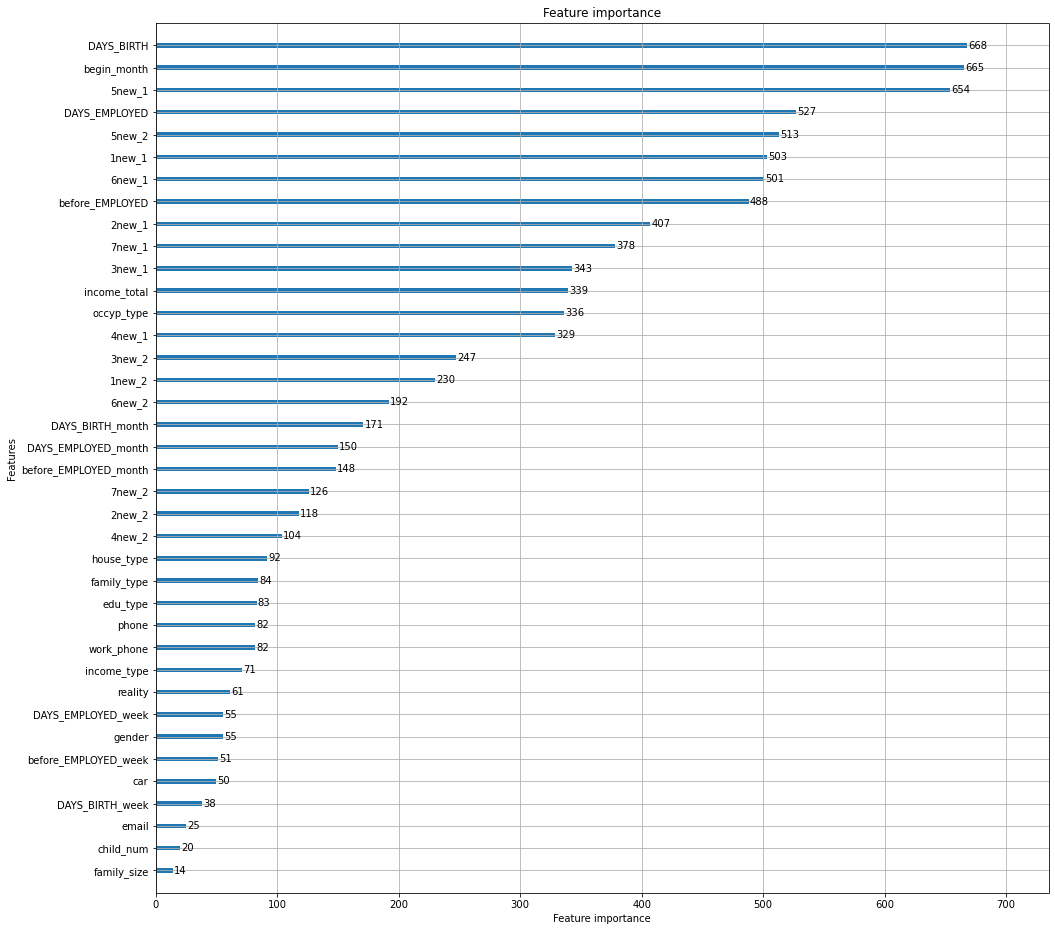

In [148]:
from lightgbm import plot_importance
plot_importance(clf, figsize=(16, 16))

# 제출용 Train

In [254]:
# train는 feature와 target 값 같이 있음
# test는 feature 값만 있다
print(train.shape, test.shape)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

random.seed(42)
lgb_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    # 데이터 분할
    train_idx, valid_idx = folds[fold] # 인덱스
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values,\
                                         train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    
    
    # 모델
    lgb = LGBMClassifier(n_estimators=1000)
    
    lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=50, verbose=100)
    
    
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

(26457, 77) (10000, 76)
====================================1============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.609198	valid_1's multi_logloss: 0.713445
[200]	training's multi_logloss: 0.51351	valid_1's multi_logloss: 0.691458
[300]	training's multi_logloss: 0.445478	valid_1's multi_logloss: 0.686283
Early stopping, best iteration is:
[330]	training's multi_logloss: 0.428789	valid_1's multi_logloss: 0.685874


====================================2============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.60566	valid_1's multi_logloss: 0.719685
[200]	training's multi_logloss: 0.511197	valid_1's multi_logloss: 0.694182
[300]	training's multi_logloss: 0.443305	valid_1's multi_logloss: 0.684878
[400]	training's multi_logloss: 0.391109	valid_1's multi_logloss: 0.683865
Early stopping, best iteration is:
[357]	training's mul

#### 파라미터 조정

In [255]:
submit.iloc[:,1:]=0
for fold in range(10):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/10

In [256]:
submit.to_csv('5submission.csv', index=False)

In [257]:
submit.head(20)

,index,0,1,2
0,26457,0.042448,0.165206,0.792346
1,26458,0.264242,0.188136,0.547622
2,26459,0.020502,0.064391,0.915107
3,26460,0.077965,0.144986,0.777049
4,26461,0.135161,0.155866,0.708973
5,26462,0.043186,0.116730,0.840084
6,26463,0.506030,0.493428,0.000543
7,26464,0.103763,0.196910,0.699327
8,26465,0.046941,0.087211,0.865848
9,26466,0.049735,0.356316,0.593950


In [258]:
from sklearn.model_selection import train_test_split
ftr_train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target, test_size = 0.2, random_state = 10)
print(train_x.shape, valid_x.shape)

from sklearn.model_selection import cross_val_score

lgb_clf = LGBMClassifier(n_estimators=100, random_state = 22)

scores = cross_val_score(lgb_clf, ftr_train , target , cv=10)

for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count+1, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores))) # 0.711 -> 0.6973

(21165, 76) (5292, 76)
교차 검증 1 정확도: 0.7120
교차 검증 2 정확도: 0.7169
교차 검증 3 정확도: 0.7056
교차 검증 4 정확도: 0.7147
교차 검증 5 정확도: 0.7052
교차 검증 6 정확도: 0.7124
교차 검증 7 정확도: 0.7086
교차 검증 8 정확도: 0.7157
교차 검증 9 정확도: 0.7127
교차 검증 10 정확도: 0.7066
평균 정확도: 0.7110


###  ========================================================================

#### 정규화 및 이상치 제거 


In [268]:
#candidate = ['income_total', 'DAYS_EMPLOYED', 'family_size']
candidate = ['income_total', 'family_size']
for cand in candidate :
    train[cand] = ((train[cand] - min(train[cand]) / min(train[cand]) - min(train[cand])))
    test[cand] = ((test[cand] - min(test[cand]) / min(test[cand]) - min(test[cand])))
    
    
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


#for cand in candidate:  
#    train = remove_outlier(train,cand)
#    test = remove_outlier(test,cand)
#len(train)
#len(test)

#### 상관관계

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = train[train.columns.tolist()].corr()
corr
plt.figure(figsize =(15,15))
sns.heatmap(corr,cmap='RdBu', annot = True) # child_num 삭제

# train.drop('child_num', axis = 1, inplace = True)
# test.drop('child_num', axis = 1, inplace = True)

<AxesSubplot:>

Error in callback <function flush_figures at 0x000002855CC538B0> (for post_execute):


KeyboardInterrupt: 

# 예측

In [224]:
## Train data
train_type = train[train['occyp_type'] != 'NAN'] # 학습용
target_train_type = train[train['occyp_type'] == 'NAN'] # 테스트용
print(train_type.shape, target_train_type.shape) ##########################################

## test 데이터
#target_train_type = test[test['occyp_type'] == 'NAN']
#train_type = test[test['occyp_type'] != 'NAN']
#print(target_train_type.shape, train_type.shape)

## 2. occyp_type은 레이블인코딩 전환, test에서 삭제 
class_le = LabelEncoder()
train_type['occyp_type'] = class_le.fit_transform(train_type['occyp_type'].values)
print(class_le.inverse_transform(train_type['occyp_type']))
#train_type['occyp_type'] = pd.factorize(train_type['occyp_type'])[0]

target_train_type.drop('occyp_type', axis = 1)

## 3. 범주형 전환
object_col = []
for col in train_type.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
        
object_col = object_col[0:-1] 

enc = OneHotEncoder()
enc.fit(train_type.loc[:,object_col])

# train
train_onehot_df = pd.DataFrame(enc.transform(train_type.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train_type.drop(object_col, axis=1, inplace=True)
train_type = train_type.reset_index()
train_onehot_df = train_onehot_df.reset_index()
train_type = pd.concat([train_type, train_onehot_df], axis=1)    

# test
test_onehot_df = pd.DataFrame(enc.transform(target_train_type.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
target_train_type.drop(object_col, axis=1, inplace=True)

target_train_type = target_train_type.reset_index()
test_onehot_df = test_onehot_df.reset_index()
target_train_type = pd.concat([target_train_type, test_onehot_df], axis=1)
print(train_type.shape, target_train_type.shape) ##########################################

# 2. train, test에서 index credit 제거  credit
training = train_type.drop(['index','credit'] , axis = 1, inplace = False) # train에서는 credit
testing = target_train_type.drop(['index', 'occyp_type','credit'], axis = 1, inplace = False)
print(training.shape, testing.shape) ##########################################

# 학습 테스트 분류
Train = training.drop('occyp_type', axis = 1, inplace = False)
target = training['occyp_type']


X_train, X_test, y_train, y_test = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 1000)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(18286, 59) (8171, 59)
['Laborers' 'Managers' 'Sales staff' ... 'Core staff' 'Laborers'
 'Security staff']
(18286, 61) (8171, 61)
(18286, 58) (8171, 57)
(13714, 57) (4572, 57) (13714,) (4572,)


### 5.직업 유형 예측

In [166]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

In [202]:
## 원핫인코딩 전환
def one_hot_encoding(df_data):
    
    # 범주형 변수 담기
    object_col = []
    for col in df_data.columns:
        if df_data[col].dtype == 'object':
            object_col.append(col)
            
    # occyp_type을 제외한 원핫인코딩
    object_col.remove('occyp_type')
    
    # 원핫인코딩
    enc = OneHotEncoder()
    enc.fit(df_data.loc[:,object_col])
    
    # 데이터 변환
    onhot_df = pd.DataFrame(enc.transform(df_data.loc[:,object_col]).toarray(),\
                                   columns=enc.get_feature_names(object_col))
    df_data.drop(object_col, axis=1, inplace=True)
    df_data = df_data.reset_index()
    onhot_df = onhot_df.reset_index()
    df_data = pd.concat([df_data, onhot_df], axis=1)    

    print("## 원핫 인코딩 진행 완료 ##")
    print(df_data.shape)
    
    return df_data

In [215]:
## 예측 정확도 파악
def predict_type(df_train_data, df_target_data):
    Train = df_train_data.drop('occyp_type', axis = 1, inplace = False)
    target = df_train_data['occyp_type']

    X_train, X_test, y_train, y_test = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.20,
                                                    random_state = 1000)

    print("## train / test 분할 완료 ##")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    print("## 예측을 진행합니다 ##")
    rf_clf = RandomForestClassifier(n_estimators = 1000, random_state=20)
    rf_clf.fit(X_train , y_train)
    pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy)) 
    
    # 적용
    print('모델 적용중.............')
    pred1 = rf_clf.predict(df_target_data)
    
    class_le = LabelEncoder()
    df_train_data['occyp_type'] = class_le.fit_transform(df_train_data['occyp_type'].values)
    
    df_target_data['occyp_type'] = class_le.inverse_transform(pred1).tolist()
    df_target_data['occyp_type'].value_counts()
    print(df_train_data.shape, df_target_data.shape)
    
    final_data = pd.concat([df_train_data.reset_index().drop(['level_0','index'], axis = 1),\
                            df_target_data.reset_index().drop(['level_0','index'], axis = 1)], axis = 0)
    print(final_data['occyp_type'].value_counts())
    print('완료')
    return final_data.reset_index()

#### 원핫적용

In [204]:
train = one_hot_encoding(train)
test = one_hot_encoding(test)

## 원핫 인코딩 진행 완료 ##
(26457, 61)
## 원핫 인코딩 진행 완료 ##
(10000, 60)


In [216]:
train_type = train[train['occyp_type'] != 'NAN']
target_train_type = train[train['occyp_type'] == 'NAN']
    
test_type = test[test['occyp_type'] != 'NAN']
target_test_type = test[test['occyp_type'] == 'NAN']
    
print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

## type 여부 분할 완료 ##
(18286, 59) (8171, 59) (6848, 58) (3152, 58)


#### 타겟 레이블 인코딩

In [217]:
class_le = LabelEncoder()
train_type['occyp_type'] = class_le.fit_transform(train_type['occyp_type'].values)
test_type['occyp_type'] = class_le.fit_transform(test_type['occyp_type'].values)

print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

## type 여부 분할 완료 ##
(18286, 59) (8171, 59) (6848, 58) (3152, 58)


In [221]:
train_training = train_type.drop(['credit'] , axis = 1, inplace = False)
train_target = target_train_type.drop(['occyp_type','credit'], axis = 1, inplace = False) # ★,'credit'
          
test_training = test_type
test_target = target_test_type.drop(['occyp_type'], axis = 1, inplace = False)
print("## 데이터 분할 완료 ##")
print(train_training.shape, train_target.shape, test_training.shape, test_target.shape)    

## 데이터 분할 완료 ##
(18286, 58) (8171, 57) (6848, 58) (3152, 57)


### 적용


In [223]:
train_training.columns

Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week',
       'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED',
       'before_EMPLOYED_month', 'before_EMPLOYED_week', '1new_1', '2new_1',
       '3new_1', '4new_1', '5new_1', '6new_1', '7new_1', '1new_2', '2new_2',
       '3new_2', '4new_2', '5new_2', '6new_2', '7new_2', 'gender_F',
       'gender_M', 'car_N', 'car_Y', 'reality_N', 'reality_Y',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'edu_type_Academic degree',
       'edu_type_Higher education', 'edu_type_Incomplete higher',
       'edu_type_Lower secondary', 'edu_type_Secondary / secondary special',
       'family_type_Civil marriage', 'family_type_Married',
       'family_type_Separated', 'family_type_Single / not ma

In [222]:
train = predict_type(train_training, train_target) # 0.8573 -> 원핫적용시 : 
test = predict_type(test_training, test_target) # 0.6818 -> 원핫적용시 : 

## train / test 분할 완료 ##
(14628, 57) (3658, 57) (14628,) (3658,)
## 예측을 진행합니다 ##
랜덤 포레스트 정확도: 0.9013
모델 적용중.............
(18286, 58) (8171, 58)


KeyError: "['level_0'] not found in axis"

In [209]:
train['occyp_type'] = class_le.inverse_transform(train['occyp_type']).tolist()
test['occyp_type'] = class_le.inverse_transform(test['occyp_type']).tolist()